# 3.1 - Paired Images


In this tutorial, we will see how we can get paired images between two satellites.
In particular, we will be using MODIS and GOES16.

**Context**.
MODIS is a polar-orbiting satellite with a high spatial resolution but a low temporal resolution, aka short revisit time of a single ROI.
In contrast, GOES16 is a geostationary satellite with a lower spatial resolution but a high temporal resolution.
We want to learn a transformation

**Setup**:
* Choose a region of interest
* Download and preprocess MODIS images
* Use those time stamps to download GOES16 images
* Use the timestamps and ROI to crop and preprocess the GOES16 images
* Create paired patches for all images.


In [1]:
import autoroot
import os
from pathlib import Path
import earthaccess
from goes2go import GOES # activate the rio accessor
import rioxarray  # activate the rio accessor
import xarray as xr
import pandas as pd
from dataclasses import dataclass
from datetime import datetime, timedelta


# PLOTTING
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import rasterio
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

# GOES2GO
import goes2go
from rs_tools._src.data.goes.download import goes_download

# GEOREADER
from georeader.dataarray import fromDataArray, toDataArray
from georeader.read import read_reproject, read_reproject_like
from georeader.griddata import read_to_crs, footprint

# RESAMPLE
from pyresample import kd_tree
from pyresample.geometry import SwathDefinition, GridDefinition
import numpy as np

# GEOBOX
from odc.geo.xr import xr_coords
from odc.geo.geom import BoundingBox
from odc.geo.geobox import GeoBox
from odc.geo.geom import Geometry
from odc.geo.crs import CRS

from odc.geo.data import ocean_geom, country_geom


from dotenv import load_dotenv

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/juanjohn/miniconda/envs/rs_tools/lib/python3.11/site-packages/goes2go/data.py:519: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1H")),
/home/juanjohn/miniconda/envs/rs_tools/lib/python3.11/site-packages/goes2go/NEW.py:188: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1H")),


## Parameters

### Period of Interest (POI)

In this first part, we want to generate a period of interest. 
Essentially, we want to get a time series of MODIS images.
We need to define some time boundaries.

* **Period**: `T=[2010-10-01, 2010-10-02]`
* **Time Constraints**
  * Hours: `"09:00:00"` and `"20:00:00"`
  * Minutes: ...

### Region of Interest (ROI)

We also need to define our region of interest (ROI).

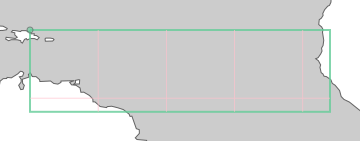

In [2]:
# create a bounding box from xy
lon_bnds = [-70, -15]
lat_bnds = [20, 5]
bbox = BoundingBox.from_xy(x=lon_bnds, y=lat_bnds, crs="4326")

# initialize geobox
resolution = 0.25 # degrees
modis_gbox = GeoBox.from_bbox(bbox, resolution=resolution, crs="4326")

modis_gbox

In [3]:
bbox.bbox
bbox_string = ' '.join(map(str,bbox.bbox))
bbox_string

'-70 5 -15 20'

### Directory Management

In [4]:
pipeline_core_dir = Path("/pool/usuarios/juanjohn/data/iti/pipeline_paired_test/")

# raw data
modis_raw_dir = pipeline_core_dir.joinpath("modis/raw")
goes16_raw_dir = pipeline_core_dir.joinpath("goes16/raw")

# clean data
modis_clean_dir = pipeline_core_dir.joinpath("modis/clean")
goes16_clean_dir = pipeline_core_dir.joinpath("goes16/clean")

# patched data
modis_mlready_dir = pipeline_core_dir.joinpath("modis/mlready")
goes16_mlready_dir = pipeline_core_dir.joinpath("goes16/mlready")

## Download MODIS Data

Now, we can use our constraints to download MODIS data

In [5]:
from rs_tools._src.data.modis.downloader_aqua import download as aqua_downloader

from IPython.utils import io

with io.capture_output() as captured:
    aqua_downloader(
        start_date="2020-10-01",
        end_date="2020-10-02",
        start_time="09:00:00",
        end_time="21:00:00",
        save_dir=str(modis_raw_dir),
        region=bbox_string,
        cloud_mask=True, 
    );   

2024-07-04 12:57:03.027 | INFO     | rs_tools._src.data.modis.downloader_aqua:download:88 - Initializing AQUA Downloader...
2024-07-04 12:57:03.028 | INFO     | rs_tools._src.data.modis.downloader_aqua:download:97 - Downloading AQUA Data...
2024-07-04 12:57:07.267 | INFO     | rs_tools._src.data.modis.download:modis_download:96 - Satellite: Aqua
2024-07-04 12:57:07.268 | INFO     | rs_tools._src.data.modis.download:modis_download:107 - Data Product: MYD021KM
2024-07-04 12:57:07.271 | INFO     | rs_tools._src.data.modis.download:modis_download:151 - Search parameters: {'short_name': 'MYD021KM', 'bounding_box': (-70, 5, -15, 20)}
2024-07-04 12:57:09.653 | INFO     | rs_tools._src.data.modis.downloader_aqua:download:99 - Done!
2024-07-04 12:57:09.654 | INFO     | rs_tools._src.data.modis.downloader_aqua:download:101 - Downloading AQUA Cloud Mask...
2024-07-04 12:57:11.227 | INFO     | rs_tools._src.data.modis.download:modis_download:96 - Satellite: Aqua
2024-07-04 12:57:11.228 | INFO     

### Preprocess MODIS Data

In [6]:
from IPython.utils import io
from rs_tools._src.geoprocessing.modis.geoprocessor_modis_refactor import geoprocess

In [7]:
with io.capture_output() as captured:
    geoprocess(
        satellite_name="aqua", 
        calibration="radiance",
        read_path=modis_raw_dir,
        save_path=modis_clean_dir,
    )

2024-07-04 12:57:27.283 | INFO     | rs_tools._src.geoprocessing.modis.geoprocessor_modis_refactor:geoprocess_modis_aqua_terra:399 - Initializing AQUA GeoProcessor...
2024-07-04 12:57:27.284 | DEBUG    | rs_tools._src.geoprocessing.modis.geoprocessor_modis_refactor:geoprocess_modis_aqua_terra:400 - Path: /pool/usuarios/juanjohn/data/iti/pipeline_paired_test/modis/raw
2024-07-04 12:57:27.332 | DEBUG    | rs_tools._src.geoprocessing.modis.geoprocessor_modis_refactor:geoprocess_modis_aqua_terra:410 - Number of Files: 12
2024-07-04 12:57:30.192 | INFO     | rs_tools._src.geoprocessing.modis.geoprocessor_modis_refactor:geoprocess_modis_aqua_terra:436 - File already exists. Overwriting file: /pool/usuarios/juanjohn/data/iti/pipeline_paired_test/modis/clean/20201001150000_aqua_radiance.nc
2024-07-04 12:57:35.219 | INFO     | rs_tools._src.geoprocessing.modis.geoprocessor_modis_refactor:geoprocess_modis_aqua_terra:436 - File already exists. Overwriting file: /pool/usuarios/juanjohn/data/iti/pi

## Download GOES16 Data

### Gather All MODIS Files

In [9]:
from rs_tools._src.utils.io import get_list_filenames
from datetime import datetime

In [10]:
# list of all .hdf files in the directory
all_modis_files = get_list_filenames(modis_clean_dir, ".nc")

len(all_modis_files)

12

### Gather All Dates

In [11]:
# create date parser
data_parser = lambda x: Path(x).name.split("_")[0]
all_modis_dates = list(map(data_parser, all_modis_files))

# convert date to datetime formater
date_conversion = lambda x: datetime.strptime(x, "%Y%m%d%H%M%S")
all_modis_dates = list(map(date_conversion, all_modis_dates))
all_modis_dates

[datetime.datetime(2020, 10, 1, 15, 0),
 datetime.datetime(2020, 10, 1, 15, 5),
 datetime.datetime(2020, 10, 1, 16, 40),
 datetime.datetime(2020, 10, 1, 16, 45),
 datetime.datetime(2020, 10, 1, 18, 20),
 datetime.datetime(2020, 10, 1, 18, 25),
 datetime.datetime(2020, 10, 2, 14, 5),
 datetime.datetime(2020, 10, 2, 14, 10),
 datetime.datetime(2020, 10, 2, 15, 45),
 datetime.datetime(2020, 10, 2, 15, 50),
 datetime.datetime(2020, 10, 2, 17, 25),
 datetime.datetime(2020, 10, 2, 17, 30)]

### Download Nearest Dates

**Note**: We might get some messages saying that the nearest date is already downloaded.
This is fine because it could be that multiple SWATHs are present within the nearest date.

In [12]:
from rs_tools.goes import GOES16_BANDS
from tqdm.auto import tqdm

download = True
within = pd.to_timedelta(10, unit="minute")

# ABI Level 1b Data
G16_DL = GOES(
    satellite=16, 
    product="ABI-L1b-Rad", 
    domain='F',
    channel=GOES16_BANDS
)

In [13]:
pbar = tqdm(all_modis_dates)

goes_image_files = list()


with io.capture_output() as captured:
    for itime in pbar:
    
        goes_image_files.append(G16_DL.nearesttime(
            attime=itime,
            within=within,
            return_as="filelist",
            save_dir=goes16_raw_dir,
            download=download
        ))

# concatenate all of the image files.
goes_image_files = pd.concat(goes_image_files, axis=0)

  0%|          | 0/12 [00:00<?, ?it/s]

## Preprocess GOES16 Data

#### Organize Target Satellite Files

In [14]:
# list of all .hdf files in the directory
all_goes16_files = get_list_filenames(goes16_raw_dir, ".nc")

len(all_goes16_files)

144

#### Get Dates from Files

In [15]:
all_goes16_files[0]

'/pool/usuarios/juanjohn/data/iti/pipeline_paired_test/goes16/raw/noaa-goes16/ABI-L1b-RadF/2020/275/15/OR_ABI-L1b-RadF-M6C01_G16_s20202751500196_e20202751509504_c20202751509565.nc'

In [16]:
from rs_tools.goes import parse_goes16_dates_from_file, format_goes_dates

In [17]:
# create date parser
all_goes16_dates = list(set(map(parse_goes16_dates_from_file, all_goes16_files)))

# convert date to datetime formater
date_conversion = lambda x: datetime.strptime(x, "%Y%j%H%M%S")
all_goes16_dates = list(map(date_conversion, all_goes16_dates))


len(all_goes16_dates)

9

#### Viz - Observations

In [60]:
ts_goes = pd.Series(index=all_goes16_dates, data=np.ones_like(all_goes16_dates))
ts_modis = pd.Series(index=all_modis_dates, data=np.ones_like(all_modis_dates))

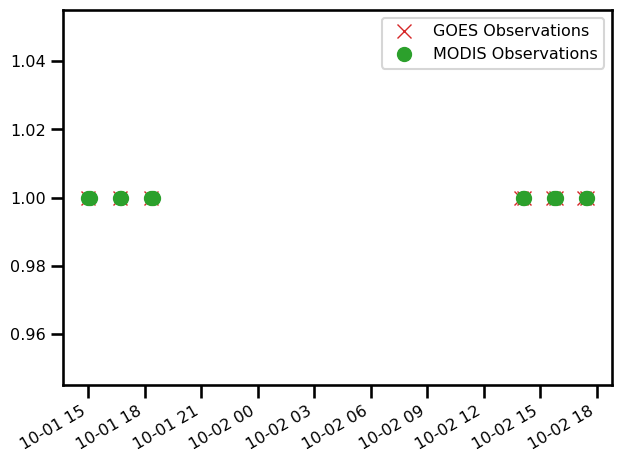

In [61]:
fig, ax = plt.subplots()

ts_goes.plot(
    ax=ax, 
    marker="x", linestyle="none", 
    markersize=10, 
    color="tab:red",
    label="GOES Observations"
)

ts_modis.plot(
    ax=ax, 
    marker="o", linestyle="none", 
    markersize=10, 
    color="tab:green",
    label="MODIS Observations"
)

plt.legend()
plt.tight_layout()
plt.show()

#### Find Nearest Time

In [62]:
# define list of timeseries
list_of_datetimes = all_goes16_dates.copy()

# define target time
target_datetime = pd.Timestamp(all_modis_dates[0])

# define window
window = pd.to_timedelta(10, unit="minute")


In [63]:
def find_nearest_time(list_of_datetimes, target_datetime, window):

    # define list of timeseries
    datetimes = pd.Series(list_of_datetimes, name="time")

    # define target time
    target_datetime = pd.Timestamp(target_datetime)

    # Step 1: Filter the Series to only include datetimes within the window
    within_window = datetimes[(datetimes >= (target_datetime - window)) & (datetimes <= (target_datetime + window))]

    # Step 2: Calculate the absolute time difference within the window
    time_differences = (within_window - target_datetime).abs()

    # Step 3: Identify the nearest datetime
    nearest_datetime_index = time_differences.idxmin()
    nearest_datetime = datetimes[nearest_datetime_index]
    
    return nearest_datetime

In [64]:
nearest_datetime = find_nearest_time(
    list_of_datetimes,
    target_datetime,
    window
)
nearest_datetime

Timestamp('2020-10-01 15:00:19')

In [65]:
# convert to goes16 string
goes16_datetime_str = datetime.strftime(nearest_datetime, "%Y%j%H%M%S")
goes16_datetime_str

'2020275150019'

In [66]:
query_goes_files = list(filter(lambda x: goes16_datetime_str in x, all_goes16_files))
len(query_goes_files)

16

In [67]:
all_modis_dates[0]

datetime.datetime(2020, 10, 1, 15, 0)

In [68]:
paired_files = list()

for imodis_date in all_modis_dates:
    # define target_time
    target_datetime = pd.Timestamp(imodis_date)

    nearest_time = find_nearest_time(
        list_of_datetimes,
        target_datetime,
        window
    )

    if nearest_time is not None:
        # get MODIS files
        modis_datetime_str =  datetime.strftime(imodis_date, "%Y%m%d%H%M%S")
        query_modis_files = list(filter(lambda x: modis_datetime_str in x, all_modis_files))

        # get goes files
        goes16_datetime_str = datetime.strftime(nearest_datetime, "%Y%j%H%M%S")
        query_goes_files = list(filter(lambda x: goes16_datetime_str in x, all_goes16_files))
        
        paired_files.append(dict(modis=query_modis_files,goes=query_goes_files))

### Load & Preprocess

* Load MODIS Image from Time
* Preprocess + ROI
* Use ROI to Preprocess GOES

In [79]:
from rs_tools._src.geoprocessing.goes.geoprocessor_goes16_refactor import geoprocess_goes16_file
from rs_tools._src.geoprocessing.modis.geoprocessor_modis_refactor import regrid_to_regular

In [80]:
# geoprocess_goes16_file??

In [81]:
date_pbar = tqdm(paired_files)
with io.capture_output() as captured:
    for ifiles in date_pbar:
    
        # regrid to regular grid
        
        # load MODIS
        date_pbar.set_description(f"Loading MODIS Satellite...")
        ds_modis = xr.open_dataset(ifiles["modis"][0])
        
        # regrid to regular grid
        # preserve coordinates
        date_pbar.set_description(f"Regridding MODIS...")
        band_wavelength = ds_modis.band_wavelength
        time = ds_modis.time
        ds_modis = regrid_to_regular(ds_modis["radiance"], resolution=0.05)
        ds_modis["band_wavelength"] = band_wavelength
        ds_modis["time"] = time
        ds_modis
    
        # grab transformations
        date_pbar.set_description(f"Grabbing Transformations...")
        gbox = GeoBox.from_bbox(ds_modis.rio.bounds(), shape=ds_modis.rio.shape, crs=ds_modis.rio.crs)
    
        # load GOES with MODIS ROI Information
        date_pbar.set_description(f"Geoprocessing GOES16 Satellites....")
        ds_goes = geoprocess_goes16_file(
            ifiles["goes"],
            resolution=1_000, 
            geometry=gbox,
            method="bounding_box",
        )
    
        # reproject MODIS to GOES
        date_pbar.set_description(f"Reprojecting MODIS to GOES....")
        ds_modis = ds_modis.rio.reproject_match(ds_goes)
        
        break
    

  0%|          | 0/12 [00:00<?, ?it/s]

#### Viz - Images

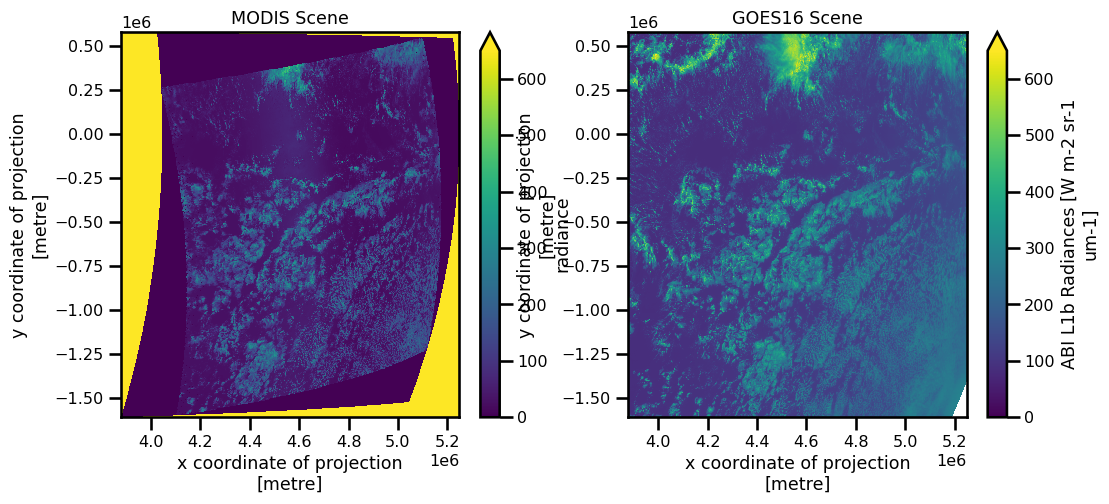

In [82]:
fig, ax = plt.subplots(ncols=2, figsize=(12,5))


ds_modis.radiance.isel(band=0).plot(ax=ax[0], vmin=0.0, vmax=650)
ds_goes.radiance.isel(band=0).plot(ax=ax[1], vmin=0.0, vmax=650)


ax[0].set(
    title="MODIS Scene",
)

ax[1].set(
    title="GOES16 Scene",
)

plt.show()

#### A Bit More Beauty

In [83]:
ds_modis_subset = ds_modis.sel(x=slice(4.2e6, 5.0e6), y=slice(-1.25e6, 0.0e6))
ds_goes_subset = ds_goes.sel(x=slice(4.2e6, 5.0e6), y=slice(-1.25e6, 0.0e6))


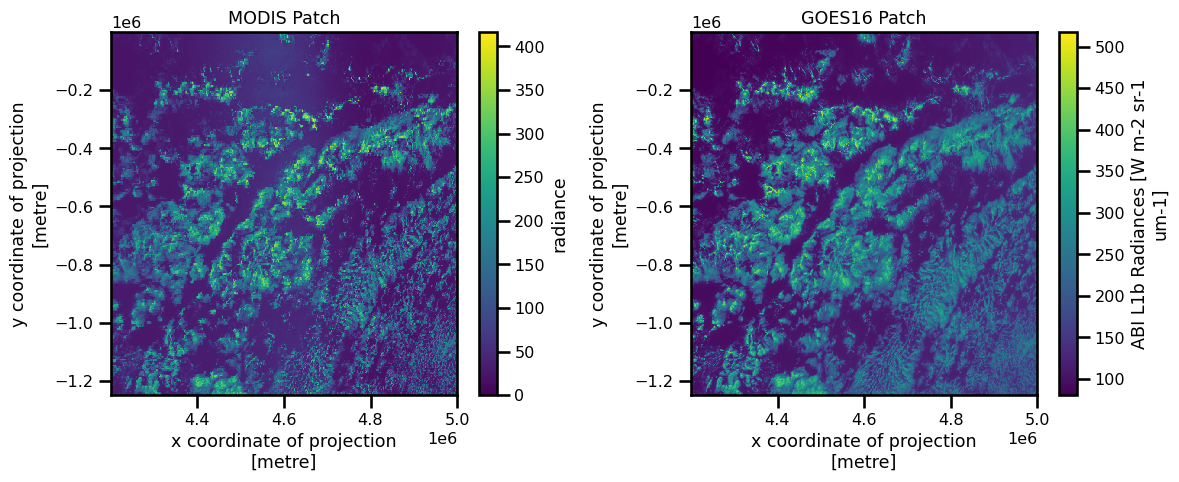

In [84]:
fig, ax = plt.subplots(ncols=2, figsize=(12,5))

ds_modis_subset.radiance.isel(band=0).plot(ax=ax[0], )
ds_goes_subset.radiance.isel(band=0).plot(ax=ax[1], )

ax[0].set(
    title="MODIS Patch",
)

ax[1].set(
    title="GOES16 Patch",
)
plt.tight_layout()
plt.show()

#### Viz - Histogram

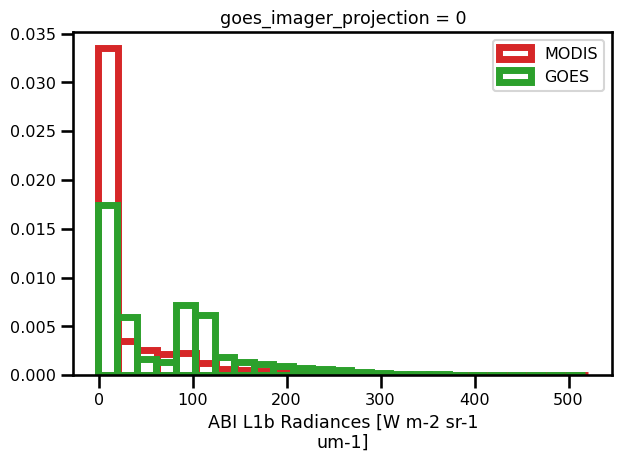

In [85]:
fig, ax = plt.subplots()
ds_modis_subset.radiance.plot.hist(
    ax=ax, bins=25, fill=False, edgecolor="tab:red", linewidth=5, label="MODIS", density=True)
ds_goes_subset.radiance.plot.hist(
    ax=ax, bins=25, fill=False, edgecolor="tab:green", linewidth=5, label="GOES", density=True)

plt.legend()
plt.tight_layout()
plt.show()


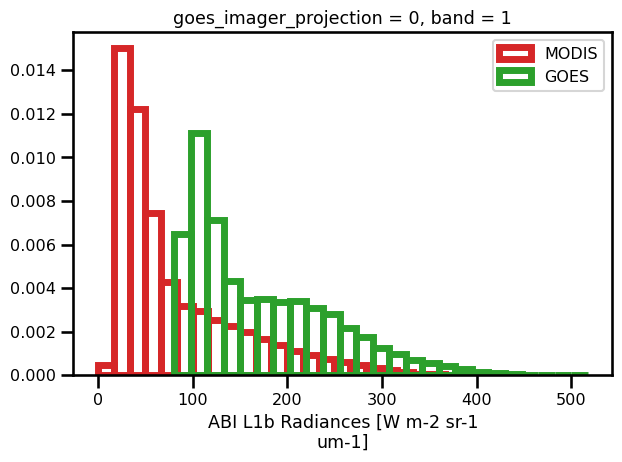

In [86]:
fig, ax = plt.subplots()
ds_modis_subset.radiance.isel(band=0).plot.hist(
    ax=ax, bins=25, fill=False, edgecolor="tab:red", linewidth=5, label="MODIS", density=True)
ds_goes_subset.radiance.isel(band=0).plot.hist(
    ax=ax, bins=25, fill=False, edgecolor="tab:green", linewidth=5, label="GOES", density=True)

plt.legend()
plt.tight_layout()
plt.show()
